In [1]:
###################################################################################################
#
# Copyright (C) 2022 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch

import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))

from PIL import Image
from collections import OrderedDict
import cv2
import ai8x
from datasets import almond
from utils import parse_obj_detection_yaml

ai85net_almond = __import__("ai85net-tinierssd-almond")


['/home/skim945/ECE189/ai8x-training/notebooks', '/home/skim945/.pyenv/versions/3.8.11/lib/python38.zip', '/home/skim945/.pyenv/versions/3.8.11/lib/python3.8', '/home/skim945/.pyenv/versions/3.8.11/lib/python3.8/lib-dynload', '', '/home/skim945/ECE189/ai8x-training/venv/lib/python3.8/site-packages', '/home/skim945/ECE189/ai8x-training/distiller', '/home/skim945/ECE189/ai8x-training/notebooks/..', '/home/skim945/ECE189/ai8x-training/notebooks/../models/', '/home/skim945/ECE189/ai8x-training', '/home/skim945/ECE189/ai8x-training/data/ALMOND/processed']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = '/home/skim945/ECE189/ai8x-training/data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=False)

_, test_set = almond.ALMOND_get_datasets((data_path, args), load_train=False, load_test=True)

IMAGES ARE EXPECTED TO BE 168x224 !
Test dataset length: 985



In [5]:
num_classes = 2

ai8x.set_device(85, False, False)

model = ai85net_almond.ai85tinierssdalmond(num_classes=num_classes, device=device)
# Run training first, using scripts/train_svhn_tinierssd.sh
checkpoint = torch.load('../logs/2023.02.04-091509/best.pth.tar')
# checkpoint = torch.load('../logs/qat_best_q.pth.tar')
state_dict = checkpoint['state_dict']

is_multi_gpu = all([key.startswith('module') for key in state_dict.keys()])

if is_multi_gpu:

    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

else:
    model.load_state_dict(state_dict)

model = model.to(device)

Configuring device: MAX78000, simulate=False.


In [6]:
obj_detection_params_yaml_file = '../parameters/obj_detection_params_face.yaml'
obj_detection_params = parse_obj_detection_yaml.parse(obj_detection_params_yaml_file)

{'multi_box_loss': {'alpha': 2, 'neg_pos_ratio': 3, 'threshold': 0.5}, 'nms': {'min_score': 0.2, 'max_overlap': 0.3, 'top_k': 20}}


torch.Size([12, 112, 84])
tensor([[0.1964, 0.2455, 0.6548, 0.5893]])


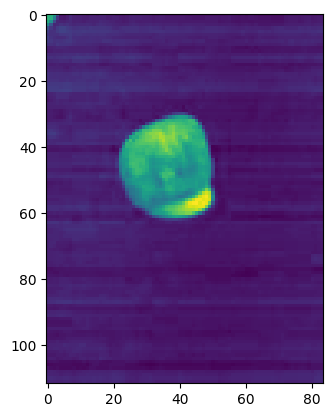

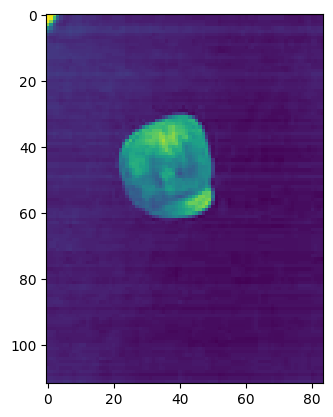

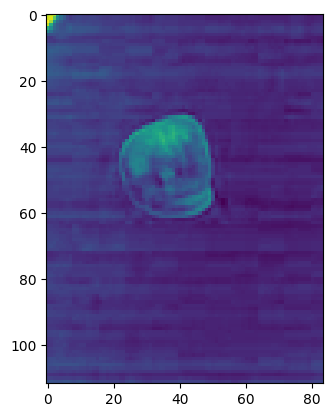

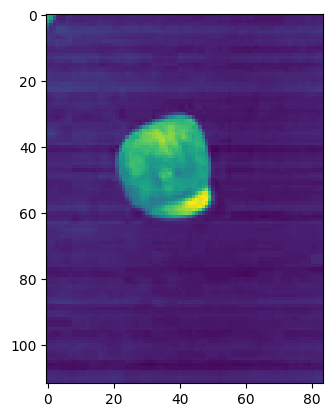

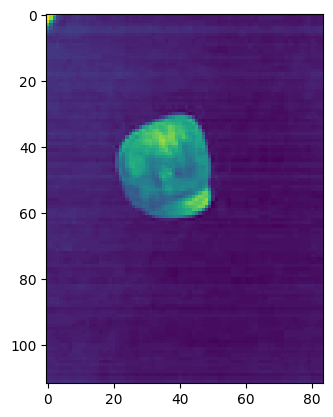

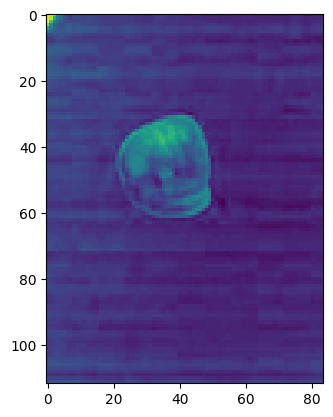

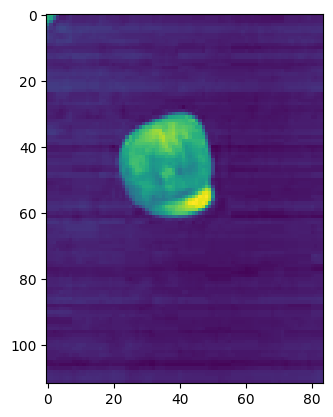

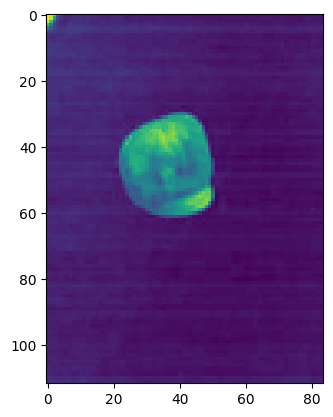

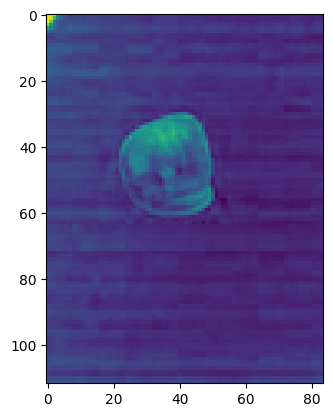

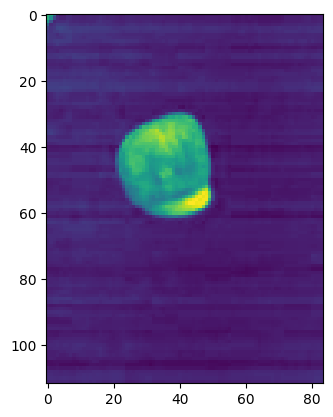

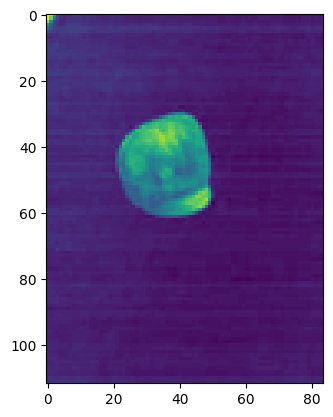

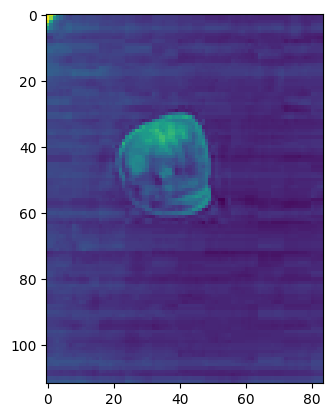

<built-in method type of Tensor object at 0x7fb3abdf2d80>
torch.Size([1, 3, 168, 224])


In [12]:
selected_idx = 8 #np.random.randint(len(test_set))
img, (boxes, lbls) = test_set[selected_idx]
print(img.shape)
print(boxes)
# print(img[0])
# plt.imshow(img[0])
# plt.show()
# plt.imshow(img[4])
for i  in range(12):
    plt.imshow(img[i])
    plt.show()
# img, (boxes, lbls) = train_set[selected_idx]
# resized_img = cv2.resize(np.mean(img, axis=0), (224, 168), interpolation=cv2.INTER_CUBIC)
# reduced_img = np.repeat(resized_img[np.newaxis, :, :], 3, axis=0)
img = np.reshape(img,(3,168,224))
print(img.type)
img2 = img.numpy()
# im = Image.fromarray(img2)
# im.save("almond.jpg")
img = img.to(device)
img_to_plot = ((128*(img.detach().cpu().numpy()+1))).astype(np.uint8)
img_to_plot = img_to_plot.transpose([1,2,0])

img_model = img.unsqueeze(0)
print(img_model.shape)
locs, scores = model(img_model)

all_images_boxes, all_images_labels, all_images_scores = \
    model.detect_objects(locs, scores,
                         min_score=obj_detection_params['nms']['min_score'],
                         max_overlap=obj_detection_params['nms']['max_overlap'],
                         top_k=obj_detection_params['nms']['top_k'])


1
1 len of boxes
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1
20 detected


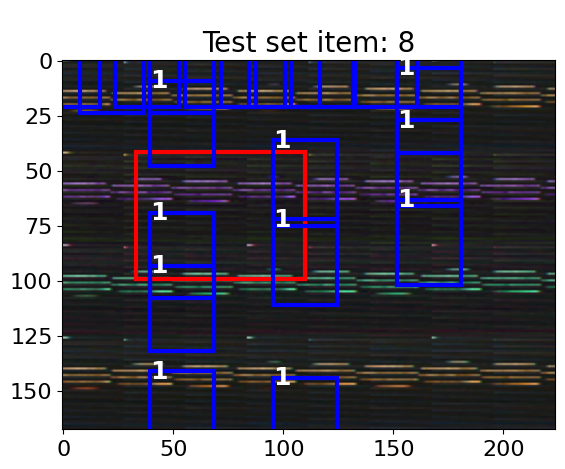

In [89]:
fig, ax = plt.subplots(1)
ax.imshow(img_to_plot)

plt.tick_params(labelsize=16)
        
subplot_title=("Test set item: " + str(selected_idx))
ax.set_title(subplot_title, fontsize = 20)

# Truth boxes
boxes_resized = [[box_coord * test_set.img_size[0] for box_coord in box] for box in boxes]
print(len(boxes_resized))
print(len(boxes), "len of boxes")
for b in range(len(boxes)):
    bb = boxes_resized[b]
    rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                            edgecolor='r', facecolor="none")
    ax.add_patch(rect)

# Predicted boxes
boxes_resized = [[box_coord * test_set.img_size[0] for box_coord in box.detach().cpu().numpy()] for box in all_images_boxes]
detected_labels = [val.item() if val.item() != 10 else 0 for val in all_images_labels[0]]
print(detected_labels)
print(len(boxes_resized))
print(len(detected_labels), "detected")
for b in range(len(boxes_resized[0])):
    if(detected_labels[b] != 0):
        bb = boxes_resized[0][b]
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                edgecolor='b', facecolor="none")
        
        ax.text(bb[0],(bb[1]), detected_labels[b], verticalalignment='center', color='white', fontsize=18, weight='bold')
        ax.add_patch(rect)    
plt.show()